In [ ]:
!pip install tsplib95

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import random
import operator
from tqdm.notebook import tqdm
import tsplib95
import networkx as nx
import pylab

In [4]:
# city class that stores the ID of the city
class City:
    def __init__(self, ID):
        self.ID = ID

In [6]:
# function that returns the distance bw 2 cities
# using the distance matrix from the problem
def distance_between_cities(city1, city2):
    return distance_matrix[city1.ID, city2.ID]

In [7]:
# Route class that stores the route and its fitness score
class Route:
    def __init__(self, route):
        self.route = route
        self.fitness = 0

    def get_fitness(self):

        distance = 0.0
        for i in range(len(self.route) - 1):
            distance += distance_between_cities(self.route[i], self.route[i+1])
        distance += distance_between_cities(self.route[-1], self.route[0])

        self.fitness = 1 / float(distance)
        return self.fitness

In [8]:
# function to generate random population
# which is a random collection of routes
def generate_random_population(size, cities):
    population = []
    for _ in range(size):
        population.append(random.sample(cities, len(cities)))
    return population

In [9]:
# rank the routes in a population based on fitness score
def rank_population(population):
    fitness = {}
    for i, route in enumerate(population):
        fitness[i] = Route(route).get_fitness()
    return np.array(sorted(fitness.items(), key=operator.itemgetter(1), reverse=True))

In [49]:
# selecting the best routes from a population to carry forward
# to the next generation
def get_mating_pool(ranked_pop, population, elite_size):
    mating_pool = []
    ref = ranked_pop[:, 1].cumsum() / ranked_pop[:, 1].sum()
    for i in range(elite_size):
        mating_pool.append(population[int(ranked_pop[i][0])])
    for _ in range(len(ranked_pop) - elite_size):
        # val = np.random.rand()
        pos = int(np.random.rand() * 10)
        mating_pool.append(population[pos])
    return mating_pool

In [50]:
# function to combine 2 routes to produce an offspring
def reproduce(parent1, parent2):
    ind = np.array([int(np.random.rand() * len(parent1)), int(np.random.rand() * len(parent1))])
    cross_over = parent1[ind.min():ind.max()+1]
    rest = [gene for gene in parent2 if gene not in cross_over]
    cross_over = random.sample(cross_over, len(cross_over))
    return (rest + cross_over)

In [51]:
# handling breeding in the entire population
# elites are carried forward directly 
def breed(mating_pool, elite_size):
    children = []
    elites = mating_pool[:elite_size]
    children.extend(elites)
    # mating_pool = mating_pool[elite_size:]
    for i in range(len(mating_pool)):
        children.append(reproduce(mating_pool[i], mating_pool[-i]))
    return children

In [52]:
# mutation in children meaning small changes in order of
# cities in a route
def mutate(route, rate):
    for i in range(len(route)):
        if np.random.rand() < rate :
            pos1 = i
            pos2 = int(np.random.rand() * len(route))
            route[pos1], route[pos2] = route[pos2], route[pos1] 
    return route

In [53]:
# extending the mutation to the entire population
def mutate_children(children, rate):
    mutated_children = []
    for child in children:
        mutated_children.append(mutate(child, rate))
    return mutated_children

In [78]:
# combining all the steps into a single pipeline
def propagate(cities, pop_size, elite_size, rate, gens):
    initial_population = generate_random_population(pop_size, cities)
    pop = initial_population
    distance = np.zeros(gens)
    for i in tqdm(range(gens)):
        ranking = rank_population(pop)
        mating_pool = get_mating_pool(ranking, pop, elite_size)
        children = breed(mating_pool, elite_size)
        next_gen = mutate_children(children, rate)
        pop = next_gen
        distance[i] = 1 / rank_population(next_gen)[0][1]
    pos = int(rank_population(next_gen)[0][0])
    city_list = []
    for city in next_gen[pos]:
        city_list.append(city.ID)
    city_list.append(city_list[0])
    return city_list, np.array(distance)

In [79]:
# trying to optimize 
problem = tsplib95.load('bays29.tsp')

# distance matrix for the 29 cities
distance_matrix = np.array(problem.edge_weights)

# assigning unique IDs to the 29 cities
cities = []
for i in range(29):
    cities.append(City(ID=i))

# simulating 200 generations
gens = 100
best_order, best_distance = propagate(cities, 100, 20, 0.01, gens)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'distance')

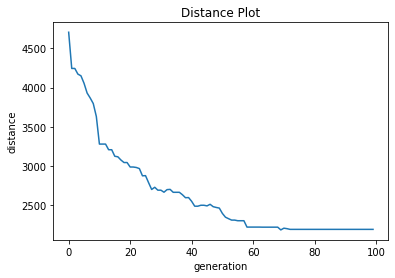

In [83]:
# plot of the best distance with generation
plt.plot(np.arange(gens), best_distance)
plt.title("Distance Plot")
plt.xlabel('generation')
plt.ylabel('distance')

In [88]:
 print(f"The overall distance reduced from {best_distance[0]} to {best_distance[-1]}.")

The overall distance reduced from 4705.0 to 2195.0.


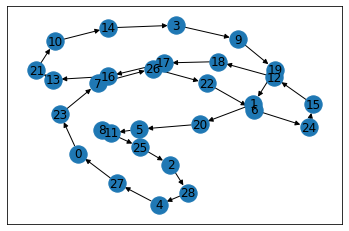

In [100]:
# visualising the best route (saturation)
edges = [(best_order[i], best_order[i+1]) for i in range(len(best_order)-1)]
G = nx.DiGraph()
for node in best_order[:-1]:
    G.add_node(node)
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=True)